# the Phat Distribution #

## In Search of Two Tails ##

Many phenomena are understood to exhibit fat tails: insurance losses, wealth distribution, [rainfall](https://hess.copernicus.org/articles/17/851/2013/hess-17-851-2013.pdf), etc. These are one-tailed phenomenom (usually bounded by zero) for which many potential distributions are applicable: Weibull, Levy, Frechet, Paretos I-IV, the generalized Pareto, the Extreme Value distribution etc.

For two-tailed phenomenon, such as financial asset returns, there are only two, and decidedly imperfect, candidates:

+ Levy-Stable Distribion 
    + the Levy-Stable is bounded in the range $\alpha \in (0, 2]$ with $\alpha = 2$ being the Gaussian distribution. Thus, the Levy-Stable *only* exhibits fat tails with tail index $\alpha < 2$ and undefined variance.
    + Unfortunately, equity returns in particular are known to have both a [second moment](https://fan.princeton.edu/fan/FinEcon/chap1.pdf) AND [fat tails](https://papers.tinbergen.nl/98017.pdf), meaning $\alpha > 2$, which the Levy-Stable does not support.
+ Student's T
    + the Student's T is the most popular distribution for modelling asset returns as it does exhibit fat tails and it is power law-*like*.
    + unfortunately, the Student's T only *tends* toward a power law in the extreme tails and so can still heavily underestimate unlikely events.
    + also, the Student's T is symmetric and cannot accomodate different tail indices in either tail. Nor can the skewed Student's T, which is asymmetric, but accepts only a single tail index.

*we should note that an asymmetric Student's T has* [been proposed](https://www.sciencedirect.com/science/article/abs/pii/S0304407610000266) *to address this.*

As a result of the seeming intractability of this problem, academics and risk managers often opt for a non-parametric or "tail-only" approach.

+ For instance, [Papenbrock et al. 2016](references.ipynb) and many others use the generalized Pareto to focus solely on VaR.
+ [Nystrom and Skoglund (2002)](references.ipynb) proposed two-pareto tails with a Gaussian kernel density in the body.

These models are useful, no doubt, but perhaps we can do better.

## the Double Pareto ##

The simplest approach to two-tailed power laws is two combine two Paretos, reflecting one so that it is left-tailed.

*Note: going forward we will generally use the term "Pareto" to refer to the "Generalized Pareto"*

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

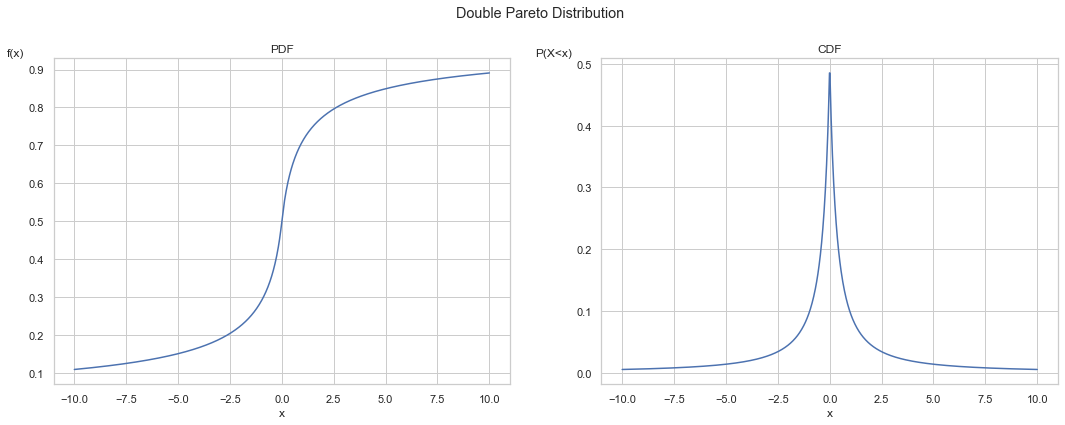

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import phat as ph

dbl = ph.dists.DBLGP()
shape = 2
x = np.linspace(-10, 10,1000)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(x, dbl.cdf(x, shape))
ax2.plot(x, dbl.pdf(x, shape))

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax2.set_title('CDF')
ax1.set_title('PDF')

plt.suptitle('Double Pareto Distribution', y=1)
plt.show()

Below we can see both the CDF and PPF functions of the double Pareto track the product of its two components. The PPF chart has a `logsym` scale on the y-axis, which is awkward looking but allows log scale for both negative and positive values.

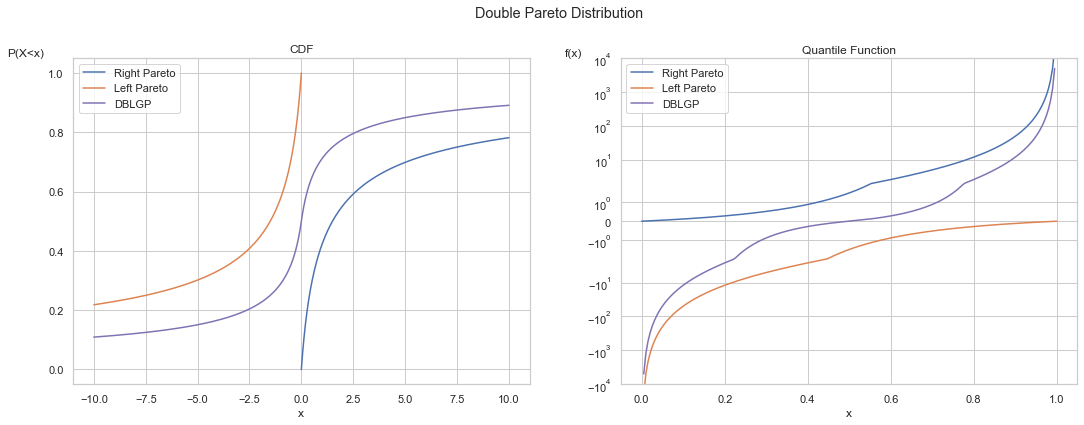

In [3]:
import scipy.stats as scist

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

xp = np.linspace(0,10,500)

ax1.plot(xp, scist.genpareto.cdf(xp, shape), label='Right Pareto')
ax1.plot(-xp, scist.genpareto.sf(xp, shape), label='Left Pareto')
ax1.plot(x, dbl.cdf(x, shape), c='C4', label='DBLGP')

qs = np.linspace(0,1,200)
ax2.plot(qs, scist.genpareto.ppf(qs, shape), label='Right Pareto')
ax2.plot(qs, -scist.genpareto.isf(qs, shape), label='Left Pareto')
ax2.plot(qs, dbl.ppf(qs, shape), c='C4', label='DBLGP')

ax2.set_yscale('symlog')
ax2.set_ylim((-10000,10000))

ax1.legend()
ax2.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax2.set_xlabel('x')
ax2.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax1.set_title('CDF')
ax2.set_title('Quantile Function')

plt.suptitle('Double Pareto Distribution', y=1)
plt.show()

We can fit the double Pareto to S&P 500 equity returns, [using the POT method](https://github.com/iagolemos1/thresholdmodeling). The result is the below, compared with the Student's T:

[*********************100%***********************]  1 of 1 completed


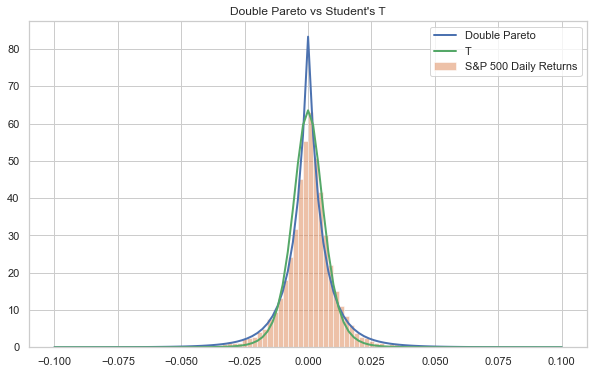

In [4]:
import yfinance as yf

sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change()[1:]

dbl = ph.dists.DBLGP()
shape = .18
loc = .005
scale = .006

x = np.linspace(-.1, .1, 101)

fig, ax = plt.subplots(1,1,figsize=(10,6))


ax.plot(x, dbl.pdf(x, shape, scale=scale), lw=2, label='Double Pareto')
ax.plot(x, scist.t(1/.18, scale=.006).pdf(x), lw=2, c='C2', label='T')
counts, bins, _ = ax.hist(
    sp_ret, 
    bins=np.linspace(-.1,.1,101), 
    color='C1',
    density=True,
    alpha=.5,
    label='S&P 500 Daily Returns'
)

ax.set_title("Double Pareto vs Student's T")

ax.legend()
plt.show()

As expected, the double Pareto is a tighter fit in the tails, but it underestimates the shoulders and significantly overestimates the peak.

## the CarBen Hybrid ##

As we saw above, the double Pareto performs well in the tails but is a poor model of returns in the body. One approach to addressing this issue is to just ignore it. Taleb would say all the impact is in the tails anyway, so the action in the body can simply be ignored. Fine, but if we can improve the performance in the body, this *should* improve our modelling.

Another approach is to combine two distributions: one for the body and one for the tail. [Carreau and Bengio (2009)](references.ipynb) propose an approach for grafting a generalized Pareto distribution onto the tail of a Gaussian. The resulting Carben hybrid is a one-tailed distribution, with properties as follows:

1. described by 5 parameters
    + $\mu$ and $\sigma$ for the Gaussian
    + $a$, $b$, and $\xi$ representing location, scale, and shape of the Pareto tail
    + as we'll see, two necessary equalities reduces the number of free parameters to 3

2. the junction point between the two distributions is the location parameter, $m$, of the Pareto tail, such that:

$$ 
f(X=a) = g(X=0) 
$$

where:

$$
f(X) \text{ is Gaussian}, g(X) \text{ is Pareto}, and
\\a = \text{location of Pareto tail}
$$

3. the derivatives of each distribution at the junction point are also equal:

$$ 
f'(X=a) = g'(X=0) 
$$

4. from (2) and (3) above, the location and scale parameters of the Pareto are (see Carreau for derivation):

$$
b = \frac{\sigma(1 + \xi)}{\sqrt{W(z)}}
\\a = \mu + \sigma\sqrt{W(z)}
$$
where:
$$
W(z) \text{ is the Lambert W function, and } z = \omega e^{\omega}
$$

So, we have just the following free parameters to estimate:

+ for the gaussian: $\mu$ and $\sigma$
+ for the generalized Pareto: $\xi$, which is $= 1/\alpha$, or the inverse of the tail index 

5. a scaling factor, $1 / \gamma$, is applied to both distributions such that the probabilities sum to 1. This scaling is also equivalent to the survival function in tail:

$$ 1 / \gamma = P(X > a) $$

$\gamma$ is computed directly as detailed in [Carreau and Bengio (2008)](#references.ipynb):

$$ \gamma = 1 + \frac{1}{2}(1 + Erf(\sqrt{W(z) / 2})) $$

where: $$ Erf \text{ is the error function}$$

Thus, the PDF for the Carben is given as:

$$
f_{\textit{right}}(x) = \left\{ \begin{array}{ll}
      \frac{1}{\gamma} f_{\mu,\sigma}(x) & \text{if } x\leq a \\
      \frac{1}{\gamma} g_{\xi,a,b}(x) & \text{if } x > a\\
\end{array} \right.
$$
where: 

$$f_{\mu,\sigma} \text{ is the Guassian and } g_{\xi,a,b} \text{ is the generalized Pareto}$$

Below we show the statistical functions for the Carben with parameters:

+ $\xi = 1/4$ (equivalent to $\alpha = 4$)
+ $a = 0$
+ $b = 1$

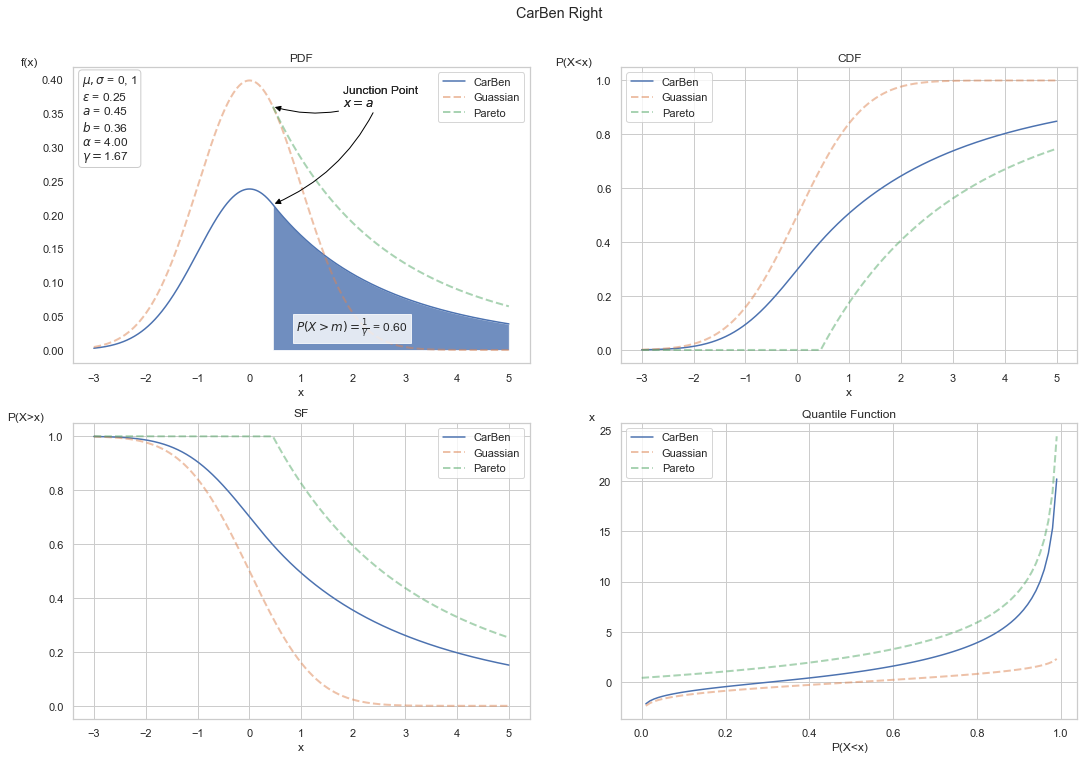

In [5]:
shape, mean, sig = 1/4, 0, 1
x = np.linspace(-3, 5, 1000)
dist = ph.dists.CarBenHybrid(shape, mean, sig)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

tailprops = dict(ls='--', lw=2, alpha=.5)
ax1.plot(x, dist.pdf(x), label='CarBen')
ax1.plot(x, dist.body.pdf(x), label='Guassian', **tailprops)
ax1.plot(x[x>dist.a], dist.tail.pdf(x[x>dist.a]), label='Pareto', **tailprops)

paramtxt = r'$\mu, \sigma$ = ' + f'{dist.mu:.0f}, {dist.sig:.0f}'
paramtxt += '\n'
paramtxt += r'$\epsilon$ = ' + f'{dist.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a$ = ' + f'{dist.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b$ = ' + f'{1 / dist.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha$ = ' + f'{1 / dist.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma = $' + f'{dist.gamma:.2f}'
ax1.text(
    .02,.69, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

txt = 'Junction Point\n' + r'$x = a$' 
arrowprops = dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=-.2", fc='black', ec='black'
)
ax1.annotate(
    txt, xy=(dist.a, dist.tail.pdf(dist.a)), xytext=(dist.a*4, dist.tail.pdf(dist.a)),
    arrowprops=arrowprops
)
ax1.annotate(
    txt, xy=(dist.a, dist.pdf(dist.a)), xytext=(dist.a*4, dist.tail.pdf(dist.a)),
    arrowprops=arrowprops
)

txt = r'$P(X > m) = \frac{1}{\gamma}$ = ' + f'{1 / dist.gamma:.2f}'
ax1.text(
    dist.a*2, dist.pdf(dist.a)/8, txt,
    bbox=dict(boxstyle='square', ec='w', fc='w', alpha=.8)
)
ax1.fill_between(x[x>dist.a], dist.pdf(x[x>dist.a]), alpha=.8)
ax1.grid(False)
ax2.plot(x, dist.cdf(x), label='CarBen')
ax2.plot(x, dist.body.cdf(x), label='Guassian', **tailprops)
ax2.plot(x, dist.tail.cdf(x), label='Pareto', **tailprops)

ax3.plot(x, dist.sf(x), label='CarBen')
ax3.plot(x, dist.body.sf(x), label='Guassian', **tailprops)
ax3.plot(x, dist.tail.sf(x), label='Pareto', **tailprops)

q = np.linspace(0,.99,101)
ax4.plot(q, dist.ppf(q), label='CarBen')
ax4.plot(q, dist.body.ppf(q), label='Guassian', **tailprops)
ax4.plot(q, dist.tail.ppf(q), label='Pareto', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)', loc='top', rotation='horizontal')

ax4.set_xlabel('P(X<x)')
ax4.set_ylabel('x', loc='top', rotation='horizontal')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('SF')
ax4.set_title('Quantile Function')

plt.suptitle('CarBen Right', y=.95)

plt.show()

Reflecting the CarBen is trivial. One need only invert the Pareto location, $a$, as well as the $x$ values, resulting in the pdf as:

$$
f_{\textit{left}}(x) = \left\{ \begin{array}{ll}
      \frac{1}{\gamma} g_{\xi,-a,b}(-x) & \text{if } y < a \\
       \frac{1}{\gamma} f_{\mu,\sigma}(x) & \text{if } y \geq a\\
\end{array} \right.
$$

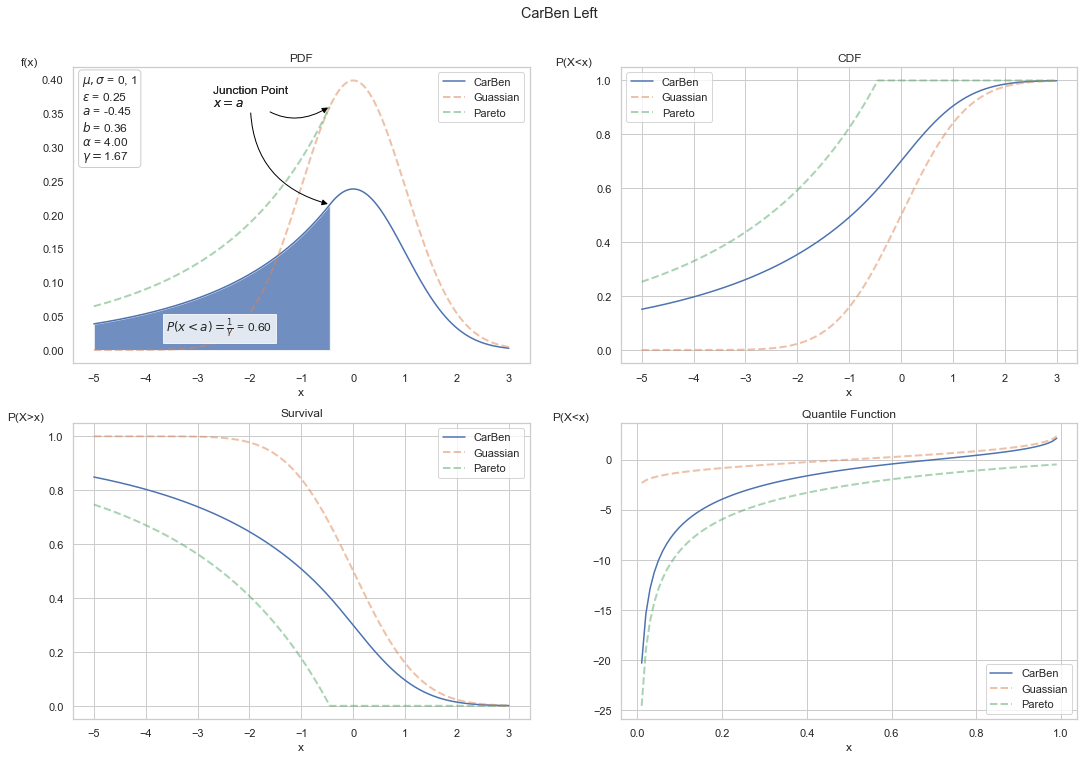

In [6]:
x = np.linspace(-5, 3, 1000)

dist = ph.dists.CarBenHybrid(-shape, mean, sig)

fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

tailprops = dict(ls='--', lw=2, alpha=.5)
ax1.plot(x, dist.pdf(x), label='CarBen')
ax1.plot(x, dist.body.pdf(x), label='Guassian', **tailprops)
ax1.plot(x[x<dist.a], dist.tail.pdf(-x[x<dist.a]), label='Pareto', **tailprops)

paramtxt = r'$\mu, \sigma$ = ' + f'{dist.mu:.0f}, {dist.sig:.0f}'
paramtxt += '\n'
paramtxt += r'$\epsilon$ = ' + f'{dist.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a$ = ' + f'{dist.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b$ = ' + f'{1 / dist.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha$ = ' + f'{1 / dist.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma = $' + f'{dist.gamma:.2f}'
ax1.text(
    .02,.69, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

txt = 'Junction Point\n' + r'$x = a$' 
arrowprops = dict(
    arrowstyle="-|>", connectionstyle="arc3,rad=.4", fc='black', ec='black'
)
ax1.annotate(
    txt, xy=(dist.a, dist.tail.pdf(-dist.a)), xytext=(dist.a*6, dist.tail.pdf(-dist.a)),
    arrowprops=arrowprops
)
ax1.annotate(
    txt, xy=(dist.a, dist.pdf(-dist.a)), xytext=(dist.a*6, dist.tail.pdf(-dist.a)),
    arrowprops=arrowprops
)
txt = r'$P(x < a) = \frac{1}{\gamma}$ = ' + f'{1 / dist.gamma:.2f}'
ax1.text(
    dist.a*8, dist.pdf(dist.a)/8, txt,
    bbox=dict(boxstyle='square', ec='w', fc='w', alpha=.8)
)
ax1.fill_between(x[x<dist.a], dist.pdf(x[x<dist.a]), alpha=.8)
ax1.grid(False)
ax2.plot(x, dist.cdf(x), label='CarBen')
ax2.plot(x, dist.body.cdf(x), label='Guassian', **tailprops)
ax2.plot(x, 1 - dist.tail.cdf(-x), label='Pareto', **tailprops)

ax3.plot(x, dist.sf(x), label='CarBen')
ax3.plot(x, dist.body.sf(x), label='Guassian', **tailprops)
ax3.plot(x, 1 - dist.tail.sf(-x), label='Pareto', **tailprops)

q = np.linspace(0,.99,101)
ax4.plot(q, dist.ppf(q), label='CarBen')
ax4.plot(q, dist.body.ppf(q), label='Guassian', **tailprops)
ax4.plot(q, -dist.tail.ppf(1 - q), label='Pareto', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)', loc='top', rotation='horizontal')

ax4.set_xlabel('x')
ax4.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.suptitle('CarBen Left', y=.95)

plt.show()

## Pareto Hybrids with Asymmetric Tails:  a Mixture Model ##

The CarBen is two-tailed, but thin-tailed in the left and fat-tailed in the right. We can arrive at a two fat-tailed model by mixing between a left-tailed and a right-tailed version. This was briefly suggested by [Carreau and Bengio (2009)](#references.ipynb) (though not implemented).

If both the left- and right-tailed CarBen's have the same characteristics in the body (i.e. the Gaussian distributions are the same), the two will mix interchangeably between the junction points with the impact of mixing experienced mainly in the tails. The mixed model can be made symmetrical by providing the same shape parameter to both components, OR each tail can have a unique tail index as necessary. Thus, the distribution adds only one or zero new free parameters.

Mixing between continuous models is achieved simply as a weighted average in both the PDF, CDF, and, by extension, other characteristics:

$$
F(x) = \sum\limits_{i=1}^nw_iF_i(x)
\\f(x) = \sum\limits_{i=1}^nw_if_i(x)
$$

The default weightings between the components is 50/50, i.e. $w_i = .5$. Thus, we arrive at the Phat distribution as:

$$
f_{\textit{phat}}(x) = 0.5*f_{\textit{left}}(x) + 0.5*f_{\textit{right}}(x)
\\F_{\textit{phat}}(x) = 0.5*F_{\textit{left}}(x) + 0.5*F_{\textit{right}}(x)
$$

Below we show a symmetrical Phat, however, one with the Gaussian mean shifted positive and with a higher volatility, and so parameters are:

+ $\xi_l = 1/5$
+ $\xi_r = 1/5$
+ $\mu = 2$
+ $\sigma = 2$

In [7]:
shape, mean, sig = 1/5, 2, 2
x = np.linspace(-10+mean, 10+mean, 1000)
dist1 = ph.Phat(mean, sig, shape, shape)

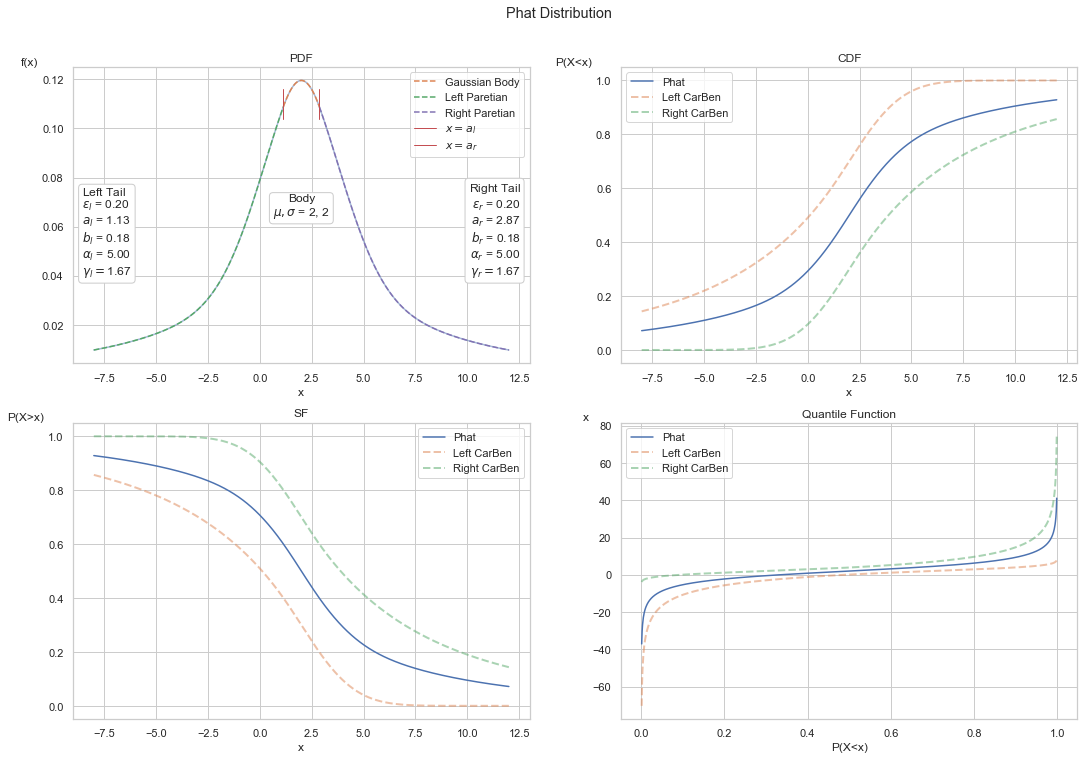

In [8]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(x, dist1.pdf(x), alpha=.5)
x_body = np.linspace(dist1.left.a, dist1.right.a, 100)
x_left = np.linspace(x[0], dist1.left.a, 100)
x_right = np.linspace(dist1.right.a, x[-1], 100)
ax1.plot(x_body, dist1.pdf(x_body), c='C1', ls='--', label='Gaussian Body')
ax1.plot(x_left, dist1.pdf(x_left), c='C2', ls='--', label='Left Paretian')
ax1.plot(x_right, dist1.pdf(x_right), c='C4', ls='--', label='Right Paretian')

ax1.axvline(
    dist1.left.a, .825, .925, 
    c='r', lw=1, label=r'$x = a_l$')
ax1.axvline(dist1.right.a, .825, .925, c='r', lw=1, label=r'$x = a_r$')

paramtxt = 'Body'
paramtxt += '\n'
paramtxt += r'$\mu, \sigma$ = ' + f'{dist1.mu:.0f}, {dist1.sig:.0f}'

ax1.text(
    .5, .5, paramtxt, ha='center',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

paramtxt = r'Left Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist1.xi_l:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{dist1.left.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / dist1.left.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist1.left.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist1.right.gamma:.2f}'

ax1.text(
    .02,.3, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Right Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_r$ = ' + f'{dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_r$ = ' + f'{dist1.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_r$ = ' + f'{1 / dist1.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_r = $' + f'{dist1.right.gamma:.2f}'

ax1.text(
    .98,.3, paramtxt, ha='right',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax1.legend()
ax1.set_title('PDF - Phat')

tailprops = dict(ls='--', lw=2, alpha=.5)
ax2.plot(x, dist1.cdf(x), label='Phat')
ax2.plot(x, dist1.left.cdf(x), label='Left CarBen', **tailprops)
ax2.plot(x, dist1.right.cdf(x), label='Right CarBen', **tailprops)

ax3.plot(x, dist1.sf(x), label='Phat')
ax3.plot(x, dist1.left.sf(x), label='Left CarBen', **tailprops)
ax3.plot(x, dist1.right.sf(x), label='Right CarBen', **tailprops)

q = np.linspace(0,.999,1000)
ax4.plot(q, dist1.ppf(q), label='Phat')
ax4.plot(q, dist1.left.ppf(q), label='Left CarBen', **tailprops)
ax4.plot(q, dist1.right.ppf(q), label='Right CarBen', **tailprops)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)', loc='top', rotation='horizontal')

ax4.set_xlabel('P(X<x)')
ax4.set_ylabel('x', loc='top', rotation='horizontal')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('SF')
ax4.set_title('Quantile Function')

plt.suptitle('Phat Distribution', y=.95)

plt.show()

We can see above the properties shared between the left and right tails. The only statistical difference between each tail is the location, $a$.

Below we show an example of two assymetric blends, one with a thinner left tail and one thicker. The left tails of both blends are identical. We can see the thicker tail twists lower near the body, of course, leading to a thicker tail in the extreme.

As we can see, simply by providing different left tail shapes, the tails end up with entirely different parameters overall.

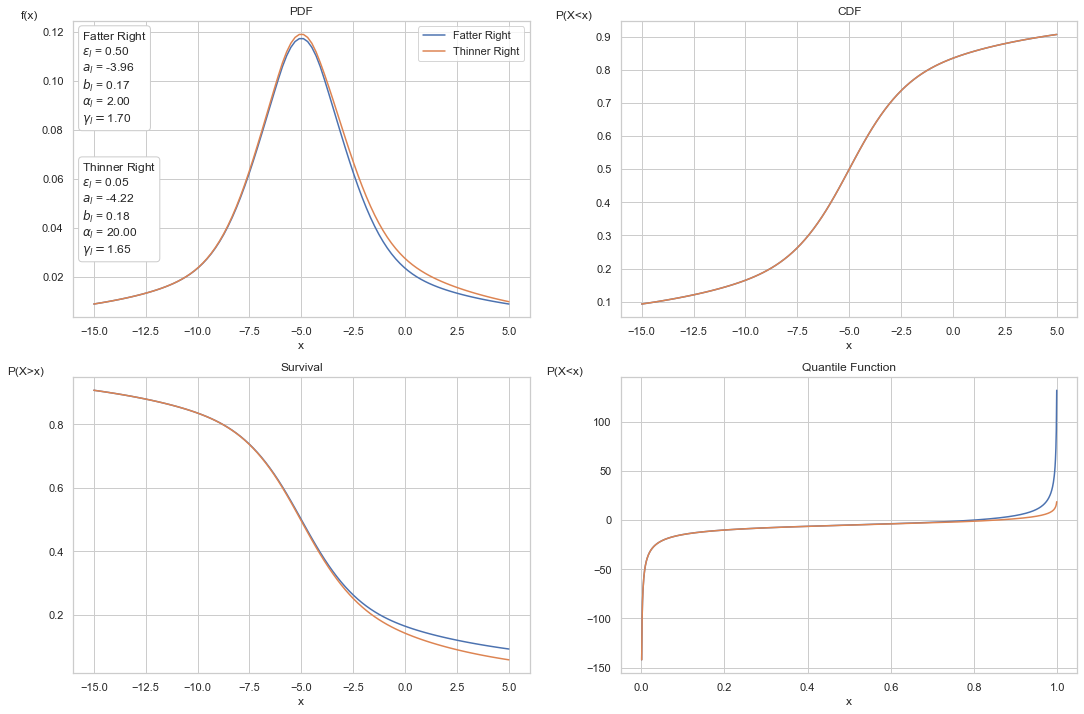

In [9]:
mean, sig = -5, 2
x = np.linspace(-10+mean, 10+mean, 100)
shape_l1, shape_r = 1/2, 1/2
dist1 = ph.Phat(mean, sig, shape_l1, shape_r)
shape_l2, shape_r = 1/2, 1/20
dist2 = ph.Phat(mean, sig, shape_l2, shape_r,)

fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(x, dist1.pdf(x), label='Fatter Right')
ax1.plot(x, dist2.pdf(x), label='Thinner Right')

paramtxt = r'Fatter Right$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{dist1.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / dist1.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist1.right.gamma:.2f}'

ax1.text(
    .02,.975, paramtxt, va='top',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Thinner Right$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist2.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{dist2.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / dist2.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist2.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist2.right.gamma:.2f}'

ax1.text(
    .02,.2, paramtxt, va='bottom',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

ax2.plot(x, dist1.cdf(x))
ax2.plot(x, dist1.cdf(x))

ax3.plot(x, dist1.sf(x))
ax3.plot(x, dist2.sf(x))

q = np.linspace(0,.999,1000)
ax4.plot(q, dist1.ppf(q))
ax4.plot(q, dist2.ppf(q))

ax1.legend()

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax2.set_xlabel('x')
ax2.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax3.set_xlabel('x')
ax3.set_ylabel('P(X>x)', loc='top', rotation='horizontal')

ax4.set_xlabel('x')
ax4.set_ylabel('P(X<x)', loc='top', rotation='horizontal')

ax1.set_title('PDF')
ax2.set_title('CDF')
ax3.set_title('Survival')
ax4.set_title('Quantile Function')

plt.show()

## Pitfalls ##

One important issue overlooked in the above analysis is the autoregressive nature of share prices. One underlying key assumption in the above is that each daily return is an independent observation. Instead, both the mean and volatility of daily returns seem to be correlated with recent historical observations. ARMA and GARCH models are often used to address this. Stochastic volatility models are also used, like the [Heston](https://en.wikipedia.org/wiki/Heston_model), which exhibits random Gaussian variation with reversion to a long-term average volatility.

[Mandlebrot (1996)](#references.ipynb) proposed a fractal model with his characteristic fat tails and "long-term dependence" (also known as long-term memory), which allows for the influence of more distant historical observations.

There are different approaches that can be used to account for auto-correlation in fat tails.

+ a "declustering" technique was proposed in [Coles(2001)](references.ipynb) that groups nearby fat-tail observations into a single observation. This approach has been criticized as it removes information.
+ threshold analysis can be performed *after* an adjustment for autocorrelation has been made.

We will explore integration with dependent time-series models, but, as Taleb would likely argue, the autocorrelative effects are most abundantly experienced in the body, and the tails will have far greater influence on the payoff. So one may choose to ignore dependence structures and still get valuable results.